# GTrack

## Hand gestures detection, classification and tracking using Convolutional Neural Network on the example of the Russian Sign Language

The project demonstrates the system for detection, classification and tracking of static hand gestures of Russian Sign Language, which is based on the approach of computer vision using Convolutional Neural Network. The work is actual and represents a core pipeline for systems with gesture control and for researchers from gesture-related areas.

Author: Oleg Potkin

In [1]:
## Dependencies

# Setup visualisation format
%matplotlib inline
# Retina-display quality for figures
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2

import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Helper functions

In [3]:
## Helper function: Imshow for Tensor
def helper_imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

## Helper function to un-normalize and display an image
def unnorm_imshow(img):
    img = img / 2 + 0.5                       # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# Part 1: Data
## 1.1 Load data

In [4]:
data_dir = 'gesture_set'

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 24
# Percentage of training set to use as validation
valid_size = 0.25

# Define transforms for the training data and testing data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(hue=.05, saturation=.05),
    #transforms.RandomResizedCrop(250),
    #transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
print("Training set size = {0}".format(train_data))
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Specify the image classes
classes = ['А', 'Б', 'В', 'Г', 'Е', 'И', 'О', 'П', 'С', 'Я']

Training set size = Dataset ImageFolder
    Number of datapoints: 1031
    Root Location: gesture_set/train
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-5, 5), resample=False, expand=False)
                             ColorJitter(brightness=0, contrast=0, saturation=0.05, hue=0.05)
                             Resize(size=128, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


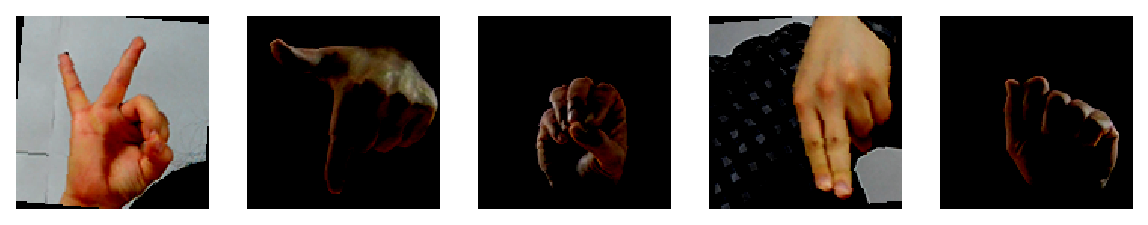

In [5]:
# Change this to the 'train_loader' or 'test_loader'
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=5)
for ii in range(5):
    ax = axes[ii]
    helper_imshow(images[ii], ax=ax, normalize=False)

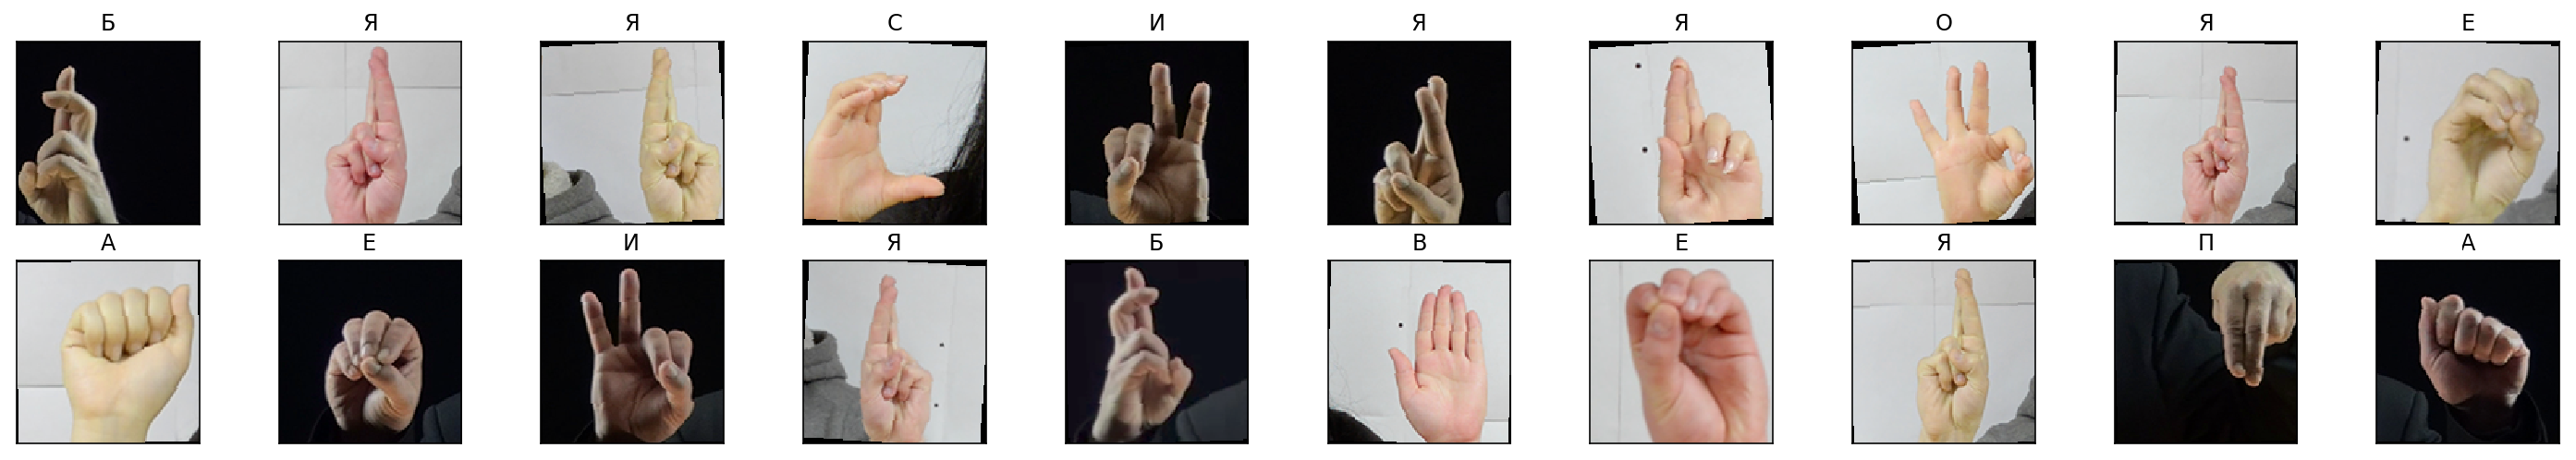

In [6]:
# Obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.next()
images = images.numpy()        # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    unnorm_imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Part 2: CNN Architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        #self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc1 = nn.Linear(64 * 16 * 16, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        # dropout layer (p=0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        #x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        # flatten image input
        #x = x.view(-1, 64 * 4 * 4)
        x = x.view(-1, 64 * 16 * 16)
        # add dropout layer
        x = self.dropout2(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
  (dropout2): Dropout(p=0.2)
)


In [8]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.728356 	Validation Loss: 0.573106
Validation loss decreased (inf --> 0.573106).  Saving model ...
Epoch: 2 	Training Loss: 1.723133 	Validation Loss: 0.571664
Validation loss decreased (0.573106 --> 0.571664).  Saving model ...
Epoch: 3 	Training Loss: 1.718859 	Validation Loss: 0.569298
Validation loss decreased (0.571664 --> 0.569298).  Saving model ...
Epoch: 4 	Training Loss: 1.711025 	Validation Loss: 0.564685
Validation loss decreased (0.569298 --> 0.564685).  Saving model ...
Epoch: 5 	Training Loss: 1.699896 	Validation Loss: 0.558267
Validation loss decreased (0.564685 --> 0.558267).  Saving model ...
Epoch: 6 	Training Loss: 1.682432 	Validation Loss: 0.552249
Validation loss decreased (0.558267 --> 0.552249).  Saving model ...
Epoch: 7 	Training Loss: 1.660518 	Validation Loss: 0.541974
Validation loss decreased (0.552249 --> 0.541974).  Saving model ...
Epoch: 8 	Training Loss: 1.617431 	Validation Loss: 0.527019
Validation loss decreased (0.54197

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load('model_augmented.pt'))

## Part 3: Evaluation

In [32]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(11):
        label = target.data[i]
        #print(label)
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.326374

Test Accuracy of     А: 66% ( 6/ 9)
Test Accuracy of     Б:  0% ( 0/ 2)
Test Accuracy of     В:  0% ( 0/ 2)
Test Accuracy of     Г: 22% ( 2/ 9)
Test Accuracy of     Е: N/A (no training examples)
Test Accuracy of     И:  0% ( 0/ 3)
Test Accuracy of     О: 12% ( 1/ 8)
Test Accuracy of     П: N/A (no training examples)
Test Accuracy of     С:  0% ( 0/ 3)
Test Accuracy of     Я:  0% ( 0/ 8)

Test Accuracy (Overall): 20% ( 9/44)


In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    unnorm_imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))